# Let's create a Movie Review Sentiment Analysis tool using the IMDb dataset



Import the necessary Libraries

In [42]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import os
print(os.listdir("../input"))
import warnings
warnings.filterwarnings('ignore')

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../input'

In [41]:
!pip install spacy
!python -m spacy download en_core_web_sm


     ---------------------------------------- 12.2/12.2 MB 2.9 MB/s eta 0:00:00
     -------------------------------------- 381.9/381.9 kB 2.2 MB/s eta 0:00:00
     -------------------------------------- 122.7/122.7 kB 3.6 MB/s eta 0:00:00
     ---------------------------------------- 45.9/45.9 kB 2.2 MB/s eta 0:00:00
     -------------------------------------- 181.6/181.6 kB 2.7 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 5.0 MB/s eta 0:00:00
     -------------------------------------- 483.8/483.8 kB 1.7 MB/s eta 0:00:00
     ---------------------------------------- 50.1/50.1 kB 2.5 MB/s eta 0:00:00
     ---------------------------------------- 1.9/1.9 MB 5.2 MB/s eta 0:00:00
     ---------------------------------------- 6.6/6.6 MB 4.6 MB/s eta 0:00:00
  Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)
     ---------------------------------------- 45.0/45.0 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing instal

Data Acquisition

Detailing the process of gathering data for our project.

download the IMDb dataset for movie reviews from this link -  https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?resource=download

In [43]:
# Using pandas to read and explore the dataset
df = pd.read_csv('C:\\Users\\Sneha\\projects\\jupyter-webscrapping\\Movie Review Sentiment Analysis\\IMDB_Dataset.csv', header=None, names=['review', 'sentiment'])
df.head(10)
df.describe()

,review,sentiment
count,50001,50001
unique,49583,3
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


Data Processing and Cleaning

Converting sentiments to binary (1 for positive, 0 for negative) and Shuffle the dataset for randomness
then Spliting the dataset into training and testing sets
Tokenize the reviews and convert them to a bag-of-words representation using CountVectorizer.

In [44]:
# Convert sentiments to binary (1: positive, 0: negative)
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the dataset into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)

# Convert reviews to a bag-of-words representation
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
train_features = vectorizer.fit_transform(train_data)
test_features = vectorizer.transform(test_data)


In [45]:
print(train_labels.notnull().sum())
print(df['sentiment'].value_counts())
print(df.columns)


39999
1.0    25000
0.0    25000
Name: sentiment, dtype: int64
Index(['review', 'sentiment'], dtype='object')


In [46]:
df.dropna(subset=['sentiment'], inplace=True)
df['sentiment'].fillna(df['sentiment'].mean(), inplace=True)
train_data, test_data, train_labels, test_labels = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)


In [47]:
#split the dataset  
#train dataset
train_reviews=df.review[:40000]
train_sentiments=df.sentiment[:40000]
#test dataset
test_reviews=df.review[40000:]
test_sentiments=df.sentiment[40000:]
print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)


(40000,) (40000,)
(10000,) (10000,)


In [48]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [50]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
df['review']=df['review'].apply(denoise_text)

In [52]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
df['review']=df['review'].apply(remove_special_characters)

In [55]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
df['review']=df['review'].apply(simple_stemmer)

#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
df['review']=df['review'].apply(remove_stopwords)

{'most', 'it', 'here', 'ain', 'had', 'ourselves', 'should', 'hadn', "isn't", "hasn't", "shan't", 'its', 'than', 'was', 'which', 'into', 'whom', 'so', 'when', 'why', 'with', 'about', 'yours', 'only', 'very', "should've", "wasn't", 'having', 'himself', 'she', 'each', 'not', 'haven', 'o', 'both', "you're", 'just', 'those', 'itself', 'who', 'ours', 'were', 'yourself', 'herself', 't', "she's", "that'll", 'or', 'him', 'such', 'against', "hadn't", 'through', 'once', 'further', 'now', 'are', 're', "you'll", 'more', 'didn', 'again', 'where', 'theirs', 'am', 'there', "mightn't", 'd', 'on', 'then', 'doing', 'our', 'some', 'mustn', 'shouldn', 'before', 'they', 'did', 'other', 'an', "it's", 'being', 'because', 'aren', 'the', 'her', 'own', 'until', "shouldn't", 'weren', 'off', 'you', 'does', 'have', 'has', 'couldn', 'ma', 'can', 'shan', 'he', 'down', 'them', 'will', 'mightn', "couldn't", 'but', 'needn', "weren't", 'been', 'these', 've', 'over', 'be', 'at', "haven't", 'his', 'by', 'wasn', 'above', "w

In [56]:
#normalized train reviews
norm_train_reviews=df.review[:40000]
norm_train_reviews[0]

#Normalized test reviews
norm_test_reviews=df.review[40000:]
norm_test_reviews[45005]

'seen thi movi mayb 100 time never grow tire iti saw thi movi first time wa 7 year old ha left mark memori sinc enchant love stori bring sun peopl even darkest time think thi must see movi one anthoni quinn best perform ever wish tvchannel would send thi movi often ha inspir good way surli mani ani actor want meet would anthoni quinn never like silver screen ever wish anthoni quinn wa still aliv may god bless hi soul'

In [57]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (40000, 6211353)
BOW_cv_test: (10000, 6211353)


Sentiment Analysis Implementation



In [58]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 6211353)
Tfidf_test: (10000, 6211353)


In [60]:
#labeling the sentient data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(df['sentiment'])
print(sentiment_data.shape)

(50000, 1)


In [61]:
#Spliting the sentiment data
train_sentiments=sentiment_data[:40000]
test_sentiments=sentiment_data[40000:]
print(train_sentiments)
print(test_sentiments)

[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [1]]
[[1]
 [0]
 [1]
 ...
 [1]
 [0]
 [0]]


In [70]:
# Assuming train_labels and test_labels are DataFrames or Series
train_data, test_data, train_labels, test_labels = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)
train_labels = train_labels.values.ravel()
test_labels = test_labels.values.ravel()


In [71]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,train_sentiments)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments)
print(lr_tfidf)

C:\Users\Sneha\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=500, random_state=42)


C:\Users\Sneha\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=500, random_state=42)


In [72]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)


[1 0 1 ... 1 1 0]
[1 0 1 ... 1 1 0]


In [73]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.7423
lr_tfidf_score : 0.7314


In [74]:
#Classification report for bag of words 
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['positive','negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['positive','negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    positive       0.73      0.77      0.75      4921
    negative       0.76      0.72      0.74      5079

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000

              precision    recall  f1-score   support

    positive       0.69      0.81      0.75      4921
    negative       0.78      0.65      0.71      5079

    accuracy                           0.73     10000
   macro avg       0.74      0.73      0.73     10000
weighted avg       0.74      0.73      0.73     10000



In [75]:
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3658 1421]
 [1156 3765]]
[[3305 1774]
 [ 912 4009]]


In [76]:
#training the linear svm
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)
#fitting the svm for bag of words
svm_bow=svm.fit(cv_train_reviews,train_sentiments)
print(svm_bow)
#fitting the svm for tfidf features
svm_tfidf=svm.fit(tv_train_reviews,train_sentiments)
print(svm_tfidf)


C:\Users\Sneha\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(max_iter=500, random_state=42)


C:\Users\Sneha\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(max_iter=500, random_state=42)


In [77]:
#Predicting the model for bag of words
svm_bow_predict=svm.predict(cv_test_reviews)
print(svm_bow_predict)
#Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(tv_test_reviews)
print(svm_tfidf_predict)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


In [78]:
#Accuracy score for bag of words
svm_bow_score=accuracy_score(test_sentiments,svm_bow_predict)
print("svm_bow_score :",svm_bow_score)
#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(test_sentiments,svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_score)

svm_bow_score : 0.4966
svm_tfidf_score : 0.4921


In [79]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,svm_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,svm_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[  46 5033]
 [   1 4920]]
[[   0 5079]
 [   0 4921]]


In [80]:
#training the model
mnb=MultinomialNB()
#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_reviews,train_sentiments)
print(mnb_bow)
#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,train_sentiments)
print(mnb_tfidf)

C:\Users\Sneha\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()


C:\Users\Sneha\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()


In [81]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[1 0 1 ... 1 1 0]
[1 0 1 ... 1 1 0]


In [82]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.7443
mnb_tfidf_score : 0.7415


In [83]:
#Classification report for bag of words 
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)
#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.73      0.76      0.75      4921
    Negative       0.76      0.73      0.74      5079

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000

              precision    recall  f1-score   support

    Positive       0.72      0.78      0.75      4921
    Negative       0.77      0.70      0.73      5079

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



In [84]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,mnb_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,mnb_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3688 1391]
 [1166 3755]]
[[3578 1501]
 [1084 3837]]


Results Visualization

Visualize the confusion matrix

<function matplotlib.pyplot.show(close=None, block=None)>

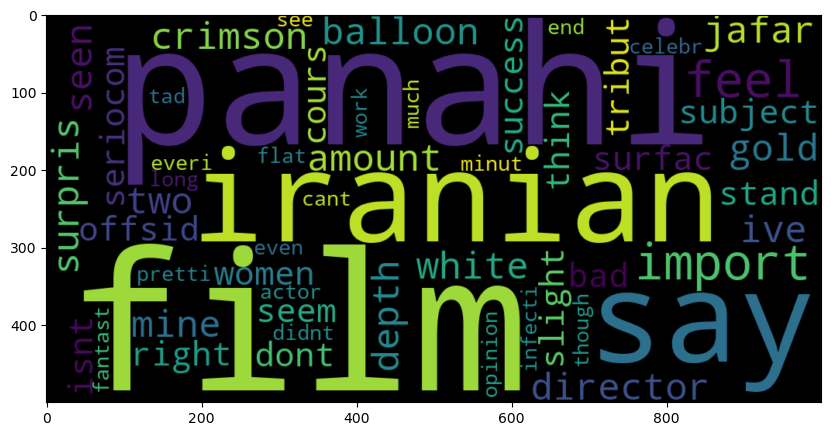

In [88]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=norm_train_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

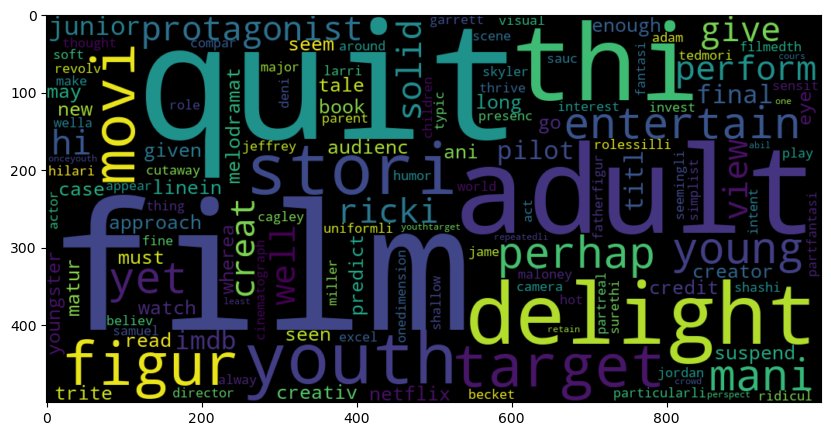

In [89]:
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=norm_train_reviews[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

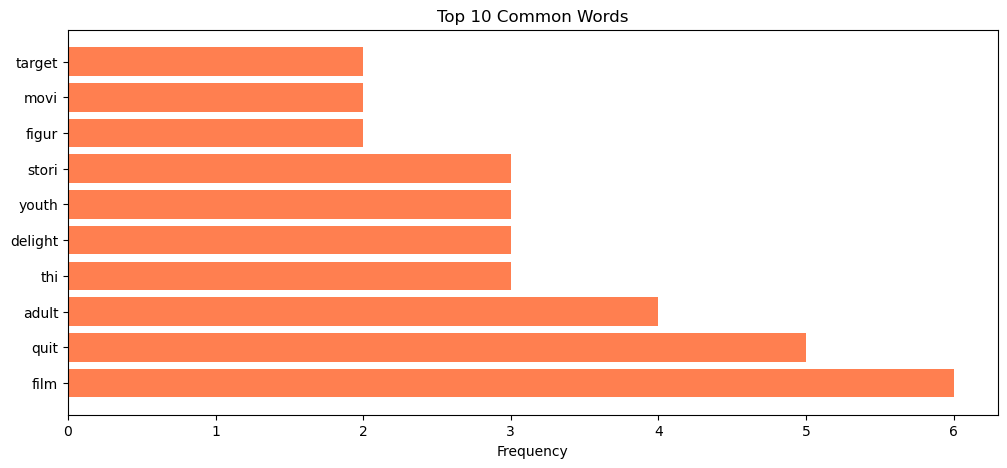

In [97]:
import matplotlib.pyplot as plt
from collections import Counter

# Example negative review text
negative_text = norm_train_reviews[8]

# Generate word frequency for bar chart
word_frequency = Counter(negative_text.split())
common_words = word_frequency.most_common(10)

# Create a bar chart for the most common words
plt.figure(figsize=(12, 5))

# Bar chart
plt.barh([word[0] for word in common_words], [word[1] for word in common_words], color='coral')
plt.title('Top 10 Common Words')
plt.xlabel('Frequency')

# Show the bar chart
plt.show()




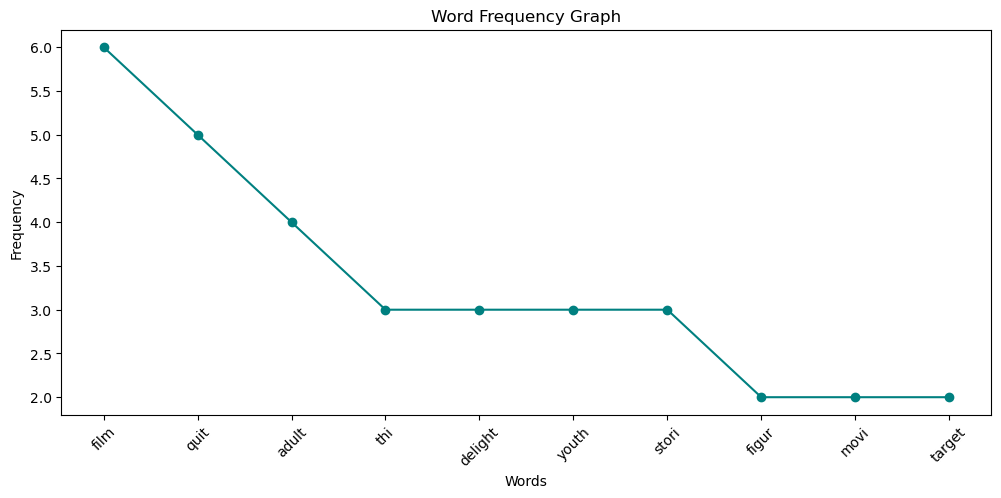

In [96]:
# Create a word frequency graph
plt.figure(figsize=(12, 5))

# Word frequency graph
plt.plot(range(len(common_words)), [word[1] for word in common_words], marker='o', linestyle='-', color='teal')
plt.title('Word Frequency Graph')
plt.xticks(range(len(common_words)), [word[0] for word in common_words], rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')

# Show the word frequency graph
plt.show()


Write-up

This project shows the sentiment analysis on a movie review dataset using natural language processing (NLP) techniques and machine learning algorithms. The dataset is sourced from IMDB reviews which contains movie reviews labeled as positive or negative sentiments. The primary goal is to build a model that can accurately classify reviews based on their sentiment.

I have followed a systematic approach, including data preprocessing, text cleaning, and feature extraction. Techniques such as denoising, removing special characters, and stemming are applied to enhance the quality of the text data. The bag-of-words (BoW) and TF-IDF representations are used to convert the textual information into numerical features.

Three machine learning models—Logistic Regression, Support Vector Machine (SVM), and Multinomial Naive Bayes—are trained and evaluated on both BoW and TF-IDF features. The models' performance is assessed using accuracy scores, confusion matrices, and classification reports.

Additionally, thiis project incorporates data visualization techniques, such as word clouds and bar charts, to provide insights into the most common words in positive and negative reviews. These visualizations help in understanding the key features contributing to sentiment classification.

In conclusion, the project showcases a comprehensive sentiment analysis pipeline, from data preprocessing to model training and evaluation, providing a valuable example of applying NLP techniques for sentiment classification in real-world datasets.






